# Assignment 5
Collaborative work by Adrian Bremer & Philipp Reinig


# Setup

## Imports

In [3]:
!pip install lemminflect

In [4]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
import statistics
import string

import nltk

from lemminflect import getAllLemmas

In [5]:
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

# Loading and exploring the Dataset

In [30]:
# remove infrequent words. you can play with this parameter as it will likely impact model quality
num_words = 5000

# Use the default parameters to keras.datasets.imdb.load_data
start_char = 1
oov_char = 2
index_from = 3

# Retrieve the dataset
(train_seqs, train_labels), (test_seqs, test_labels) = keras.datasets.imdb.load_data(start_char=start_char, oov_char=oov_char, index_from=index_from, num_words=num_words)

# Retrieve the word index file mapping words to indices
word_index = dict(sorted(keras.datasets.imdb.get_word_index().items()))
word_index["[START]"] = start_char
word_index["[OOV]"] = oov_char

print(f"First 100 elements of the word_index: {list(word_index.items())[:100]}")

# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
inverted_word_index = dict((i + index_from, word) for (word, i) in word_index.items())
# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"

inverted_word_index = dict(sorted(inverted_word_index.items()))

print(f"First 100 elements of the inverted_word_index: {list(inverted_word_index.items())[:100]}")

First 100 elements of the word_index: [('\x08\x08\x08\x08a', 68893), ('\x10own', 70879), ("'", 755), ("''", 17448), ("''a", 57351), ("''after", 64015), ("''bad", 72030), ("''cannibal", 58448), ("''clients''", 80824), ("''dark''", 66872), ("''empire", 52876), ("''family", 85943), ("''gaslight''", 58747), ("''heart''", 75354), ("''high", 66908), ("''holy", 83565), ("''human''", 61364), ("''humans''", 88090), ("''i'm", 61351), ("''if", 62727), ("''inuyasha''", 61770), ("''little''", 58164), ("''maison", 85895), ("''ned''", 62202), ("''negative''", 76149), ("''nice", 57008), ("''oh", 45418), ("''on", 66910), ("''oversexed''", 75509), ("''peeping", 81867), ("''professionals''", 76109), ("''ranma", 44903), ("''raptors''", 70722), ("''return", 55138), ("''saint", 51394), ("''scarface''", 51257), ("''sea", 49404), ("''talent", 84926), ("''terrorists''", 81627), ("''the", 20197), ("''their", 84051), ("''this", 66430), ("''thunderball", 87604), ("''troubled''", 79833), ("''unpleasant", 66417), (

In [7]:
# we cannot create a dataset :( this is because sequences are different length
# but tensors have to be "rectangular"
# train_data = tf.data.Dataset.from_tensor_slices(train_sequences, train_labels)

In [14]:
# solution is padding all sequences to the maximum length.
# first find the maximum length
seq_lengths = [len(sequence) for sequence in train_seqs]
max_seq_length = max(seq_lengths)

Minimum text length is: 11
Maximum text length is: 2494
Median text length is: 178.0
Average text length is: 238.71364


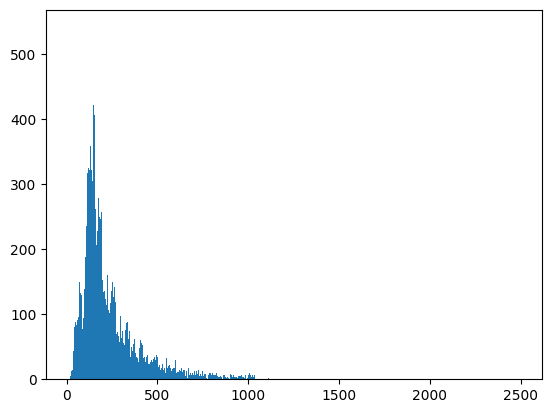

In [15]:
# overview over sequence lengths in the data
# could also look at mean, median, standard deviation...
plt.hist(seq_lengths, bins=1000)

sl_np_array = np.array(seq_lengths)
min_seq_length = np.min(sl_np_array)
median_seq_length = np.median(sl_np_array)
average_seq_length = np.average(sl_np_array)

print(f"Minimum text length is: {min_seq_length}")
print(f"Maximum text length is: {max_seq_length}")
print(f"Median text length is: {median_seq_length}")
print(f"Average text length is: {average_seq_length}")

plt.show()

In [121]:
# luckily there is a convenient function for padding
train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sqs, maxlen=max_len, padding='pre')

In [122]:
# now we can create a dataset!
train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels))

In [123]:
# all sequences are... very long
print(train_sequences_padded.shape)


(25000, 2494)


In [124]:
# it would be better to do something like this
# all sequences above maxlen will be truncated to that length
# note: pad_sequences has "pre" and "post" options for both padding and truncation. one may be better than the other!
train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=200)
train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels))

print(train_sequences_padded.shape)

(25000, 200)


In [18]:
# for fun, you can look at the word-index mappings.
# in this case, the mapping was done according to word frequency.
# you can pass reverse=True to sorted() to look at the least common words.
print("The most frequent 100 word are: ")
print(sorted(inverted_word_index.items())[2:102])

The most frequent 100 word are: 
[(4, 'the'), (5, 'and'), (6, 'a'), (7, 'of'), (8, 'to'), (9, 'is'), (10, 'br'), (11, 'in'), (12, 'it'), (13, 'i'), (14, 'this'), (15, 'that'), (16, 'was'), (17, 'as'), (18, 'for'), (19, 'with'), (20, 'movie'), (21, 'but'), (22, 'film'), (23, 'on'), (24, 'not'), (25, 'you'), (26, 'are'), (27, 'his'), (28, 'have'), (29, 'he'), (30, 'be'), (31, 'one'), (32, 'all'), (33, 'at'), (34, 'by'), (35, 'an'), (36, 'they'), (37, 'who'), (38, 'so'), (39, 'from'), (40, 'like'), (41, 'her'), (42, 'or'), (43, 'just'), (44, 'about'), (45, "it's"), (46, 'out'), (47, 'has'), (48, 'if'), (49, 'some'), (50, 'there'), (51, 'what'), (52, 'good'), (53, 'more'), (54, 'when'), (55, 'very'), (56, 'up'), (57, 'no'), (58, 'time'), (59, 'she'), (60, 'even'), (61, 'my'), (62, 'would'), (63, 'which'), (64, 'only'), (65, 'story'), (66, 'really'), (67, 'see'), (68, 'their'), (69, 'had'), (70, 'can'), (71, 'were'), (72, 'me'), (73, 'well'), (74, 'than'), (75, 'we'), (76, 'much'), (77, 'be

# Building a RNN Model for IMDB Movie Review

## Utils

### Conversions

In [43]:
def indx_to_word(i: int) -> str:
  return inverted_word_index.get(i, "UNKNOWN")

def word_to_indx(w: str) -> int:
  return word_index[w]+3

def seq_to_words(seq: list[str]) -> str:
  """
  Converts a sequence (a list of indices, decoding words) to decoded string (a list of strings the indices decode)
  """
  return [indx_to_word(indx) for indx in seq]

def seq_to_text(seq: list[str]) -> str:
  """
  Converts a sequence (a list of indices, decoding words) to decoded human readable text (one large string)
  """
  return " ".join(seq_to_words(seq))

In [49]:
print(seq_to_text(train_seqs[0]))
print(seq_to_words(train_seqs[0]))

[START] this film was just brilliant casting location scenery story direction everyone's really suited [START] part they played [OOV] you could just imagine being there robert [OOV] is an amazing actor [OOV] now [START] same being director [OOV] father came from [START] same scottish island as myself so i loved [START] fact there was a real connection with this film [START] witty remarks throughout [START] film were great it was just brilliant so much that i bought [START] film as soon as it was released for [OOV] [OOV] would recommend it to everyone to watch [OOV] [START] fly [OOV] was amazing really cried at [START] end it was so sad [OOV] you know what they say if you cry at a film it must have been good [OOV] this definitely was also [OOV] to [START] two little [OOV] that played [START] [OOV] of norman [OOV] paul they were just brilliant children are often left out of [START] [OOV] list i think because [START] stars that play them all grown up are such a big [OOV] for [START] whole

### Adjective or Adverb Check

In [50]:
# NLTK library has a really bad performance for detecting adjectives ~ 50%
def is_adjective_or_adverb_using_nltk(s: str) -> bool:
  nltk_type_of_word = nltk.pos_tag([s], tagset="universal")[0][1]
  is_adjective_or_adverb = nltk_type_of_word == "ADJ" or nltk_type_of_word == "ADV"
  #if is_adjective_or_adverb:
  print(f"{s} {'is an adjective or adverb' if is_adjective_or_adverb else f'is not an adjective or adverb, it is: {nltk_type_of_word}'}")
  return is_adjective_or_adverb

# Lemminflect's performance is > 90%, way better!
def is_adjective_or_adverb(s: str) -> bool:
  lemmas = getAllLemmas(s)
  #print(f"{s}'s lemmas: {lemmas}")
  return "ADJ" in lemmas or "ADV" in lemmas

### Preprocessing Data

In [53]:
# Pre-process a single string
def pre_process_str(s: str) -> str:

  # Remove punctuation
  def remove_punctuation(s: str) -> str:
    s = s.translate(str.maketrans('', '', string.punctuation))
    return s

  return remove_punctuation(s)


# Pre-process an entire sequence
def pre_process_sequence(seq: list[int]) -> list[int]:
  words = seq_to_words(seq)
  words_processed = [w for w in words if(w != "UNKNOWN" and  w != "[OOV]" and w != "[START]" and is_adjective_or_adverb(w))]
  return [word_to_indx(w) for w in words_processed]



In [52]:
print(f"Without processing: {seq_to_text(train_seqs[0])}")
print(f"After preprocessing: {seq_to_text(pre_process_sequence(train_seqs[0]))}")

Without processing: [START] this film was just brilliant casting location scenery story direction everyone's really suited [START] part they played [OOV] you could just imagine being there robert [OOV] is an amazing actor [OOV] now [START] same being director [OOV] father came from [START] same scottish island as myself so i loved [START] fact there was a real connection with this film [START] witty remarks throughout [START] film were great it was just brilliant so much that i bought [START] film as soon as it was released for [OOV] [OOV] would recommend it to everyone to watch [OOV] [START] fly [OOV] was amazing really cried at [START] end it was so sad [OOV] you know what they say if you cry at a film it must have been good [OOV] this definitely was also [OOV] to [START] two little [OOV] that played [START] [OOV] of norman [OOV] paul they were just brilliant children are often left out of [START] [OOV] list i think because [START] stars that play them all grown up are such a big [OO

In [19]:
# here is a high-level sketch for training RNNs

# training loop -- same thing as before!!
# our data is now slightly different (each batch of sequences has a time axis, which is kinda new)
# but all the related changes are hidden away at lower levels
def train_loop():
    for sequence_batch, label_batch in train_data:
        train_step(sequence_batch, label_batch)


# a single training step -- again, seems familiar?
def train_step(sequences, labels):
    with tf.GradientTape() as tape:
        logits = rnn_loop(sequences)
        loss = loss_fn(labels, logits)

    gradient = ...
    apply_gradients(...)


# here's where things start to change
# we loop over the input time axis, and at each time step compute the new
# hidden state based on the previous one as well as the current input
# the state computation is hidden away in the rnn_step function and could be
# arbitrarily complex.
# in the general RNN, an output is computed at each time step, and the whole
# sequence is returned. but in this case, since we only have one label for the
# entire sequence, we only use the final state to compute one output and return it.
# before the loop, the state need to be initialized somehow.
@tf.function
def rnn_loop(sequences):
    old_state = ...  # initial state

    for step in tf.range(max_len):
        x_t = sequences[:, step]
        x_t = tf.one_hot(x_t, depth=num_words)
        new_state = rnn_step(old_state, x_t)

        old_state = new_state

    o_t = output_layer(new_state)

    return o_t


# see formulas in the book ;)
def rnn_step(state, x_t):
    ...

Ellipsis
<class 'ellipsis'>
